In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as T
import pandas as pd
from sklearn.model_selection import train_test_split

floatX = theano.config.floatX

class列がp（poisonous）：有毒、e （edible）：食用の2値データ→きのこが有毒かを予測するニューラルネットワークモデルを作成


https://www.kaggle.com/datasets/uciml/mushroom-classification

In [ ]:
df = pd.read_csv('input/mushrooms.csv')
df = pd.get_dummies(df)
X = df.drop(['class_e', 'class_p'], axis=1) # 説明変数
Y = df['class_p'] # 目的変数
X=X.to_numpy()
Y=Y.to_numpy()
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
df.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,...,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


それぞれ5つのニューロンを持つ2つの隠れ層を使用した3層のニューラルネットワークモデルを作成する

各層の間の重みに対し、ガウス事前分布を仮定

$$
\begin{aligned}
p\left(w_{m, k}^{(1)}\right) &=\mathcal{N}\left(w_{m, k}^{(1)} \mid 0, \lambda_{w}^{-1}\right) \\
p\left(w_{k, d}^{(2)}\right) &=\mathcal{N}\left(w_{k, d}^{(2)} \mid 0, \lambda_{w}^{-1}\right)
\end{aligned}
$$
各層の重みの入力に非線形変換を行う
$$
f\left(\mathbf{W}, \mathbf{x}_{n}\right)=\mathbf{W}^{(2) \top} \operatorname{Tanh}\left(\mathbf{W}^{(1)^{\top}} \mathbf{x}_{n}\right)
$$

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # 各層の間の重みの初期化
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # 入力層から1つ目の隠れ層への重み
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # 1つ目の隠れ層から2つ目の隠れ層への重み
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        # 2つ目の隠れ層から出力層への重み
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # tanh(・)を用いたニューラルネットワークの構築
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # ベルヌーイ分布を用いた2値分類結果を出力
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [ ]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=5000)

Finished [100%]: Average Loss = 315.7


CPU times: user 6min 19s, sys: 4min 23s, total: 10min 43s
Wall time: 5min 39s


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb667b73410>,
      dtype=object)

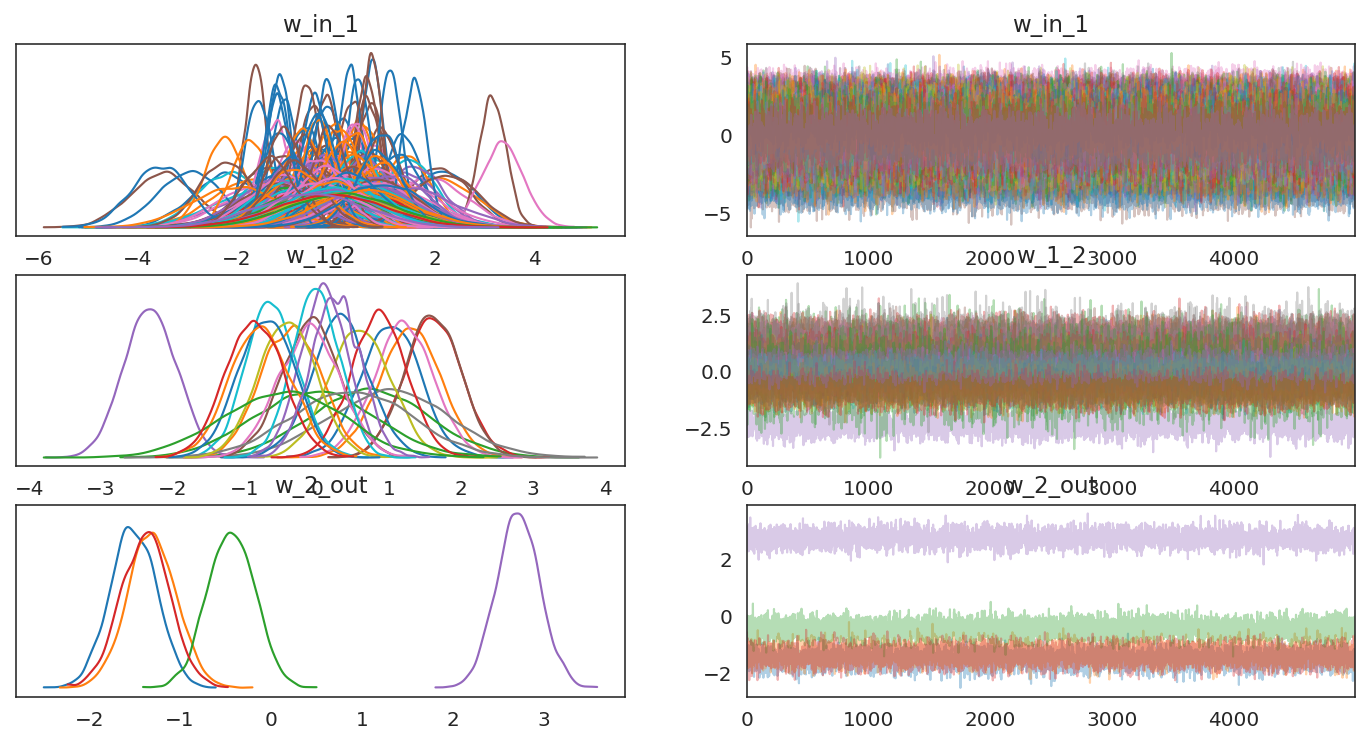

In [ ]:
pm.plot_trace(trace) #各パラメータの事後分布の描画

In [ ]:
x = T.matrix("X")
n = T.iscalar("n")
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba)

def production_step1():
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(
        trace, samples=500, progressbar=False, model=neural_network
    )

    pred = ppc["out"].mean(axis=0) > 0.5


def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [ ]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [ ]:
print("Accuracy = {}%".format((Y_test == pred).mean() * 100))

Accuracy = 99.95898277276456%
